(288, 117)
(1, 288, 117)


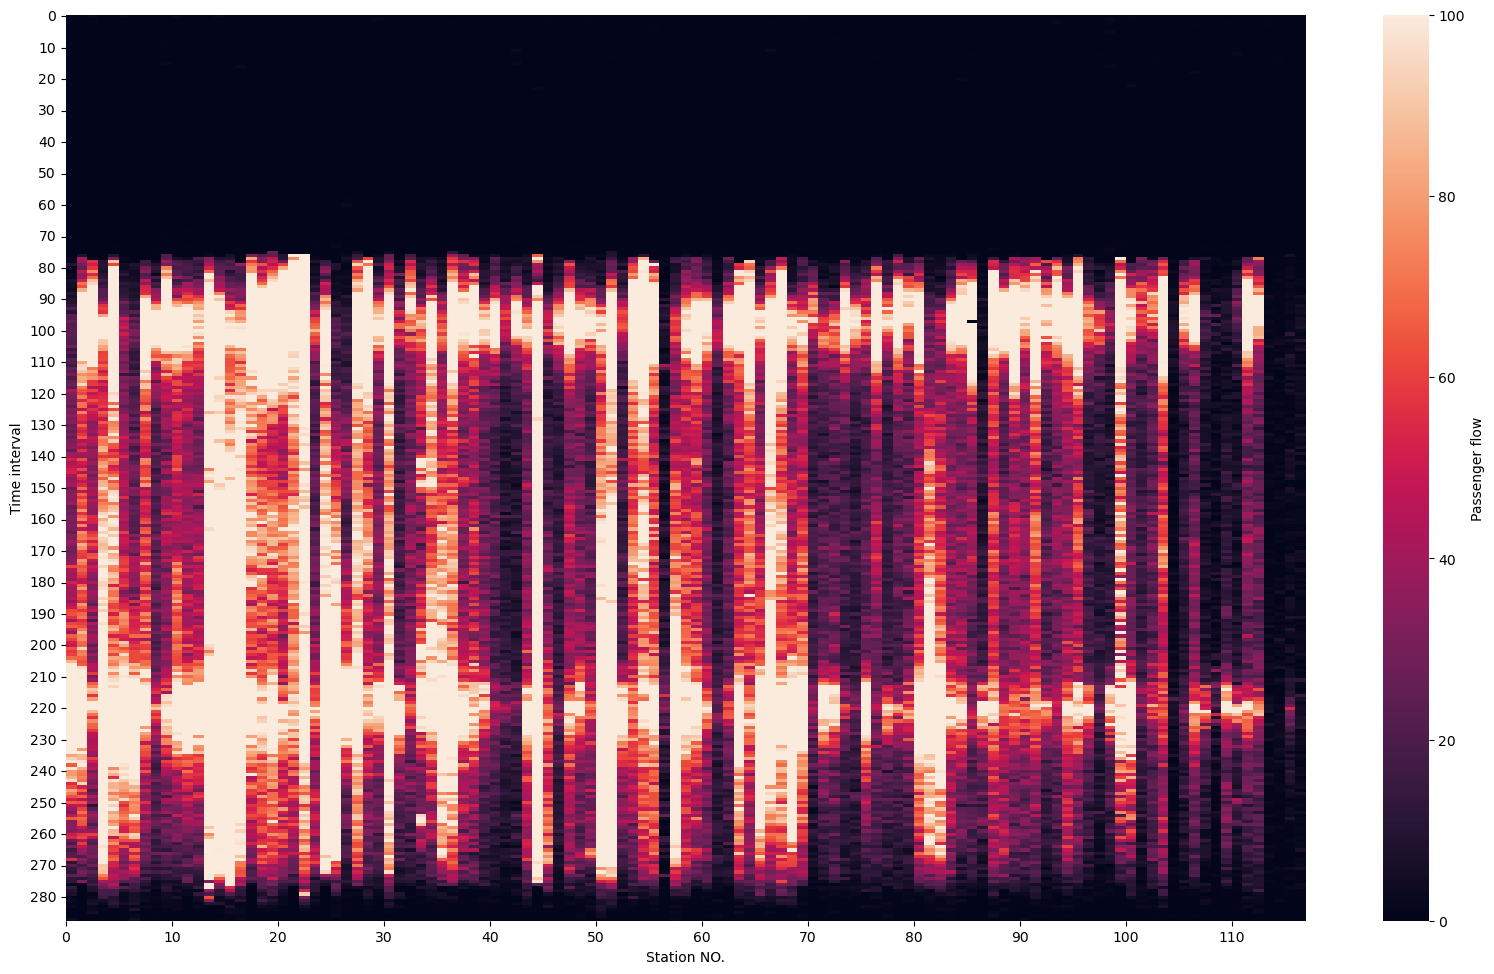

In [12]:
#读取数据
import numpy as np
np.random.seed(1000)
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pl
dense_list=[]
tensorone = scipy.io.loadmat('tensor111.mat')
dense_one = tensorone['tensor']
print(dense_one.shape)
# tensortwo = scipy.io.loadmat('tensor2.mat')
# dense_two = tensortwo['tensor']

dense_list.append(dense_one)
# dense_list.append(dense_two)
dense_tensor=np.array(dense_list)
print(dense_tensor.shape)
dim =np.shape(dense_tensor)
sparse_list=[]

#对每一行乘一个偏置值
#bais = np.round(np.random.rand(dim[0], dim[1])[:, :, np.newaxis] + 0.5 - missing_rate)
#sparse_tensor = dense_tensor * bais
#维度变化，dim[0]为1
dense_mat = dense_tensor.reshape([dim[0]*dim[1] , dim[2]])
#sparse_mat = sparse_tensor.reshape([dim[0]*dim[1] , dim[2]])
#dense_mat = dense_mat[0:dim[1], dim[2]] #取全部数据
#sparse_mat = sparse_mat[0:dim[1], dim[2]]
fig = plt.figure(figsize = (20, 12), dpi=100)
sns.heatmap(dense_mat, cbar_kws={'label': 'Passenger flow'}, vmin = 0, vmax = 100)
plt.xticks(np.arange(0, 117, 10), np.arange(0, 117, 10), rotation = 0)
plt.yticks(np.arange(0.5, 288, 10), np.arange(0, 288, 10), rotation = 0)
plt.xlabel('Station NO.')
plt.ylabel('Time interval')
#plt.savefig("5.5.svg", dpi=50,format="svg")
plt.show()

(288, 329)
(1, 288, 329)


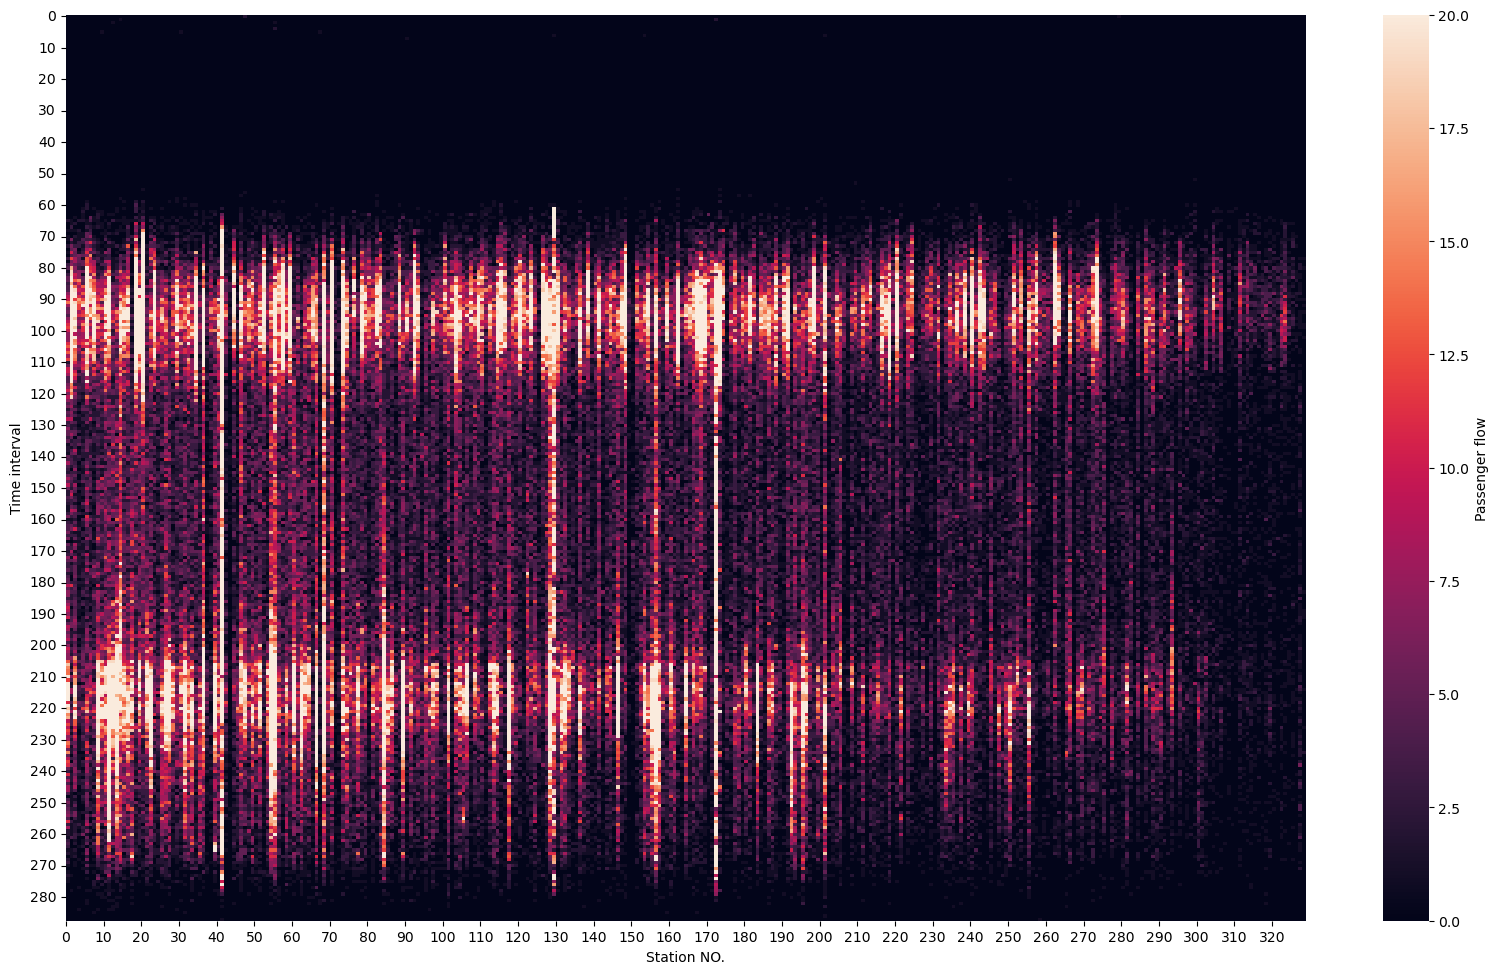

In [1]:
#读取数据
import numpy as np
np.random.seed(1000)
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pl
dense_list=[]
tensorone = scipy.io.loadmat('506.mat')
dense_one = tensorone['tensor']
print(dense_one.shape)
# tensortwo = scipy.io.loadmat('tensor2.mat')
# dense_two = tensortwo['tensor']

dense_list.append(dense_one)
# dense_list.append(dense_two)
dense_tensor=np.array(dense_list)
print(dense_tensor.shape)
dim =np.shape(dense_tensor)
sparse_list=[]

#对每一行乘一个偏置值
#bais = np.round(np.random.rand(dim[0], dim[1])[:, :, np.newaxis] + 0.5 - missing_rate)
#sparse_tensor = dense_tensor * bais
#维度变化，dim[0]为1
dense_mat = dense_tensor.reshape([dim[0]*dim[1] , dim[2]])
#sparse_mat = sparse_tensor.reshape([dim[0]*dim[1] , dim[2]])
#dense_mat = dense_mat[0:dim[1], dim[2]] #取全部数据
#sparse_mat = sparse_mat[0:dim[1], dim[2]]
fig = plt.figure(figsize = (20, 12), dpi=100)
sns.heatmap(dense_mat, cbar_kws={'label': 'Passenger flow'}, vmin = 0, vmax = 20)
plt.xticks(np.arange(0,328, 10), np.arange(0, 328, 10), rotation = 0)
plt.yticks(np.arange(0.5, 288, 10), np.arange(0, 288, 10), rotation = 0)
plt.xlabel('Station NO.')
plt.ylabel('Time interval')
#plt.savefig("5.5.svg", dpi=50,format="svg")
plt.show()

In [17]:
import numpy as np
from numpy.linalg import inv as inv #np.linalg.inv()：矩阵求逆
import tensorly as tl
import time
import scipy.io
import os
import re
from openpyxl import Workbook
import scipy.io as sio

def ten2mat(tensor, mode):#numpy.moveaxis(a, source, destination) a是数组，是原始位置，目标位置
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F') #张量展开

def mat2ten(mat, tensor_size, mode):#张量折叠
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)
# 包括任何输入矩阵 X，截断核规范（TNN）正则化的权重 α，学习率 ρ和正整数 θ 用于核规范的截断
def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_mae(var, var_hat):
    return np.sum(np.abs(var - var_hat)) / var.shape[0]

from scipy import fftpack
def svt_tnn(mat, tau, theta):
    [m, n] = mat.shape
    if 2 * m < n:
        u, s, v = np.linalg.svd(mat @ mat.T, full_matrices = 0)
        s = np.sqrt(s)
        idx = np.sum(s > tau)
        mid = np.zeros(idx)
        mid[: theta] = 1
        mid[theta : idx] = (s[theta : idx] - tau) / s[theta : idx]
        return (u[:, : idx] @ np.diag(mid)) @ (u[:, : idx].T @ mat)
def tSVST(X, beta,k,thfull=False):
    n1, n2, n3 = X.shape
    Xbar = np.fft.fft(X, axis=k)
    Wbar = np.zeros((n1, n2, n3), dtype=complex)
    if k == 0:
        theta = int(np.ceil(0.05 * min(n3, n2)))  # 0.05
        for i in range(0, int(np.ceil((n1 + 1) / 2))):
            Wbar[i, :, :] = svt(Xbar[i, :, :], beta, theta)
        for i in range(int(np.ceil((n1 + 1) / 2)), n1):
            Wbar[i, :, :] = np.conj(Wbar[n1 - i, :, :])
    elif k == 1:
        theta = int(np.ceil(0.05* min(n1, n3)))
        for i in range(0, int(np.ceil((n2 + 1) / 2))):
            Wbar[:, i, :] = svt(Xbar[:, i, :], beta, theta)
        for i in range(int(np.ceil((n2 + 1) / 2)), n2):
            Wbar[:, i, :] = np.conj(Wbar[:, n2 - i, :])
    elif k == 2:
        theta = int(np.ceil(0.05 * min(n1, n2)))
        for i in range(0, int(np.ceil((n3 + 1) / 2))):
            Wbar[:, :, i] = svt(Xbar[:, :, i], beta, theta)
        for i in range(int(np.ceil((n3 + 1) / 2)), n3):
            Wbar[:, :, i] = np.conj(Wbar[:, :, n3 - i])
    return np.real(np.fft.ifft(Wbar, axis=k))
def BM(missing_rate):
    dense_tensor = scipy.io.loadmat('tensor.mat')['tensor']
    dim1, dim2, dim3 = dense_tensor.shape
    print("dense_tensor.shape:",dense_tensor.shape)
    dim_time = dim2 * dim3
    block_window = 6
    vec = np.random.rand(int(dim_time / block_window))
    temp = np.array([vec] * block_window)
    vec = temp.reshape([dim2 * dim3], order='F')

    sparse_tensor = mat2ten(ten2mat(dense_tensor, 0) * np.round(vec + 0.5 - missing_rate)[None, :],
                            np.array([dim1, dim2, dim3]), 0)
    sparse_tensor=sparse_tensor.transpose(0, 2, 1)
    return sparse_tensor

def RM(missing_rate):
    mat_file = "missing_rate1" + str(missing_rate) + '.mat'
    if os.path.exists(mat_file):
        sparse_tensor = scipy.io.loadmat(mat_file)
        sparse_tensor = sparse_tensor['tensor']
        sparse_tensor = sparse_tensor.reshape(1, 288, 117)
        #sparse_tensor = sparse_tensor.reshape(1, 288, 329)

    else:
        bais = np.round(np.random.rand(dim[0], dim[1])[:, :, np.newaxis] + 0.5 - missing_rate)
        sparse_tensor = dense_tensor * bais
        data = np.mat(sparse_tensor)
        # 将数据保存为MAT文件
        mat_file = "missing_rate1" + str(missing_rate) + '.mat'
        sio.savemat(mat_file, {'tensor': data})
    return sparse_tensor

def NM(missing_rate):

# =============================================================================
### Non-random missing (NM) scenario:
  random_matrix = scipy.io.loadmat('random_matrix.mat')
  random_matrix = random_matrix['random_matrix']
  dense_tensor = scipy.io.loadmat('tensor.mat')['tensor']
  binary_tensor = np.zeros(dense_tensor.shape)
  for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
# =============================================================================
  sparse_tensor = np.multiply(dense_tensor, binary_tensor)
  sparse_tensor = sparse_tensor.transpose(0, 2, 1)
  return sparse_tensor

In [18]:
def LRTC(dense_tensor, sparse_tensor, alpha, rho, epsilon, maxiter,theta):
    """Low-Rank Tenor Completion with Truncated Nuclear Norm, LRTC-TNN."""
    dim = np.array(sparse_tensor.shape)
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    X = np.zeros(np.insert(dim, 0, len(dim)))  # \boldsymbol{\mathcal{X}}
    X1=np.zeros(np.insert(dim, 0, len(dim)))
    T = np.zeros(np.insert(dim, 0, len(dim)))  # \boldsymbol{\mathcal{T}}
    #print("打印出小于0的数的个数：", np.sum(T < 0))
    Z = sparse_tensor.copy()
    Z1=sparse_tensor.copy()
    print("Z1出小于0的数的个数：", np.sum(Z1 < 0))
    last_tensor = sparse_tensor.copy()
    snorm = np.sqrt(np.sum(sparse_tensor **2))
    it = 0
    while True:
        X1=X.copy()
        Z1=Z.copy()
        rho = min(rho * 1.05, 1e4)
        '''
        for k in range(dim0):
            Z[:, :, :, k] = tSVST((tensor_hat + T[:, :, :, k] / rho),alpha[k] / rho,theta,k)
        tensor_hat[pos_missing] = np.mean(Z - T / rho, axis=3)[pos_missing]
        for k in range(dim0):
            T[:, :, :, k] = T[:, :, :, k] + rho * (tensor_hat - Z[:, :, :, k])
        tol = np.sqrt(np.sum((tensor_hat - last_tensor) ** 2)) / snorm
        '''

        for k in range(len(dim)):
            X[k] = tSVST(Z, alpha[k]/rho, k)
        Z[pos_missing] = np.mean(X + T / rho, axis=0)[pos_missing]
        n= np.where(X <0)
        X[n] = X1[n]
        #print("X1小于0的数的个数：", np.sum(X1 < 0))
        #X=abs(X)
        #T = T + rho * (X - np.broadcast_to(Z, np.insert(dim, 0, len(dim))))

        tensor_hat = np.einsum('k, kmnt -> mnt', alpha, X)
        tol = np.sqrt(np.sum((tensor_hat - last_tensor) ** 2)) / snorm
        last_tensor = tensor_hat.copy()
        it += 1
        if (it + 1) % 10 == 0:
            print('Iter: {}'.format(it + 1))
            print('RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
            #print(int(np.ceil(theta * dim[k])))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break

        #Z = abs(Z)
        n=np.where(Z<0)
        Z[n]=Z1[n]
        #Z1 = abs(Z)
        #print("Z1出小于0的数的个数：", np.sum(Z1<0))

    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
    print()
    print("打印出小于0的数的个数：", np.sum(tensor_hat < 0))
    idx = np.where(tensor_hat < 0)
    output = tensor_hat[idx]
    print(output)
    return tensor_hat

In [19]:
def svt(mat, tau,theta,P=4.55):
    [m, n] = mat.shape
    if m > 2 * n:
        return svt(mat.T,tau, theta).T
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    #tau = tau**(P-1)
    idx = np.sum(0.5*s**((P-2)/2)>tau)
    #print("idx=",idx)
    vec = s[:idx].copy()
    vec[theta:] = np.maximum(vec[theta:] - tau , 0.0)
    #print("打印出小于0的数的个数：", np.sum((u[:,:idx] @ np.diag(vec) @ v[:idx,:])< 0))
    return u[:,:idx] @ np.diag(vec) @ v[:idx,:]#输出一

In [21]:
dim =np.shape(dense_tensor)
start = time.time()
alpha = np.ones(3) / 3

maxiter = 150
end = time.time()
print('Running time: %d seconds'%(end - start))

workbook = Workbook()
booksheet = workbook.active
booksheet.append(['缺失率', 'RM', 'NM', 'BM'])
missing_rate=[0.1,0.3,0.5,0.7]
listrmse=[]

for i in range(0, len(missing_rate)):

    listRow = []
    listrmseR=[]
    listRow.append(missing_rate[i])
    listmaeR = []
    listmaeR.append(" ")
    listrmseR.append(" ")

    sparse_tensor = RM(missing_rate[i])
    dim = np.array(sparse_tensor.shape)
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    rho = 1e-6# 非随机设置为1e-5，随机设置为1e-4，迭代次数更少,sz数据需设置为1e-6
    epsilon = 1e-5 # 非随机设置为1e-4，随机设置为1e-3，迭代次数更少,sz数据需设置为1e-5
    tensor_hat=LRTC(dense_tensor, sparse_tensor, alpha, rho, epsilon, maxiter,theta=20)
    listRow.append(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test]))
    listrmseR.append(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test]))
    listmaeR.append(compute_mae(dense_tensor[pos_test], tensor_hat[pos_test]))
    '''
    sparse_tensor = NM(missing_rate[i])
    dim = np.array(sparse_tensor.shape)
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    rho = 1e-5  # 非随机设置为1e-5，随机设置为1e-4，迭代次数更少
    epsilon = 1e-4  # 非随机设置为1e-4，随机设置为1e-3，迭代次数更少
    tensor_hat = LRTC(dense_tensor, sparse_tensor, alpha, rho, epsilon, maxiter,theta=30)
    listRow.append(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test]))
    listrmseR.append(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test]))
    listmaeR.append(compute_mae(dense_tensor[pos_test], tensor_hat[pos_test]))

    sparse_tensor = BM(missing_rate[i])
    dim = np.array(sparse_tensor.shape)
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    rho = 1e-5  # 非随机设置为1e-5，随机设置为1e-4，迭代次数更少
    epsilon = 1e-4  # 非随机设置为1e-4，随机设置为1e-3，迭代次数更少
    tensor_hat = LRTC(dense_tensor, sparse_tensor, alpha, rho, epsilon, maxiter,theta=30)
    listRow.append(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test]))
    listrmseR.append(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test]))
    listmaeR.append(compute_mae(dense_tensor[pos_test], tensor_hat[pos_test]))
'''
    booksheet.append(listRow)
    booksheet.append(listrmseR)
    booksheet.append(listmaeR)
workbook.save("sz1运行结果.xls")

Running time: 0 seconds
Z1出小于0的数的个数： 0
Iter: 10
RMSE: 105.066

Iter: 20
RMSE: 99.9628

Iter: 30
RMSE: 70.0735

Iter: 40
RMSE: 56.4235

Iter: 50
RMSE: 35.0356

Iter: 60
RMSE: 31.4791

Iter: 70
RMSE: 30.6419

Iter: 80
RMSE: 29.1881

Iter: 90
RMSE: 30.3671

Iter: 100
RMSE: 30.5184

Iter: 110
RMSE: 30.5217

Iter: 120
RMSE: 30.5218

Iter: 130
RMSE: 30.5218

Iter: 140
RMSE: 30.5216

Iter: 150
RMSE: 30.5217

Imputation MAPE: 0.370152
Imputation RMSE: 30.5218

打印出小于0的数的个数： 0
[]
Z1出小于0的数的个数： 0
Iter: 10
RMSE: 77.6177

Iter: 20
RMSE: 74.6639

Iter: 30
RMSE: 56.6214

Iter: 40
RMSE: 41.2079

Iter: 50
RMSE: 25.9899

Iter: 60
RMSE: 24.5561

Iter: 70
RMSE: 25.1196

Iter: 80
RMSE: 25.63

Iter: 90
RMSE: 26.0612

Iter: 100
RMSE: 26.1357

Iter: 110
RMSE: 26.1387

Iter: 120
RMSE: 26.1378

Iter: 130
RMSE: 26.1371

Iter: 140
RMSE: 26.1365

Iter: 150
RMSE: 26.1361

Imputation MAPE: 0.401652
Imputation RMSE: 26.1361

打印出小于0的数的个数： 0
[]
Z1出小于0的数的个数： 0
Iter: 10
RMSE: 94.7448

Iter: 20
RMSE: 90.4516

Iter: 30
RMSE